Annalise et traitements des données

In [174]:

import glob
from keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import rescale
from scipy.signal import convolve2d
from PIL import Image
import seaborn as sns; sns.set_theme()
from scipy import stats
import random
from collections import deque 
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
from joblib import Parallel, delayed
from scipy.stats import f_oneway
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib.patches import Patch
from keras.datasets import mnist
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.autolayout"] = True
warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
from joblib import Parallel, delayed
from scipy.stats import f_oneway
import sys
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.image as img


In [175]:
IMAGE_FOLDER_PATH = "../dogs_vs_cats/train_dog_cat"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)
WIDTH = 150
HEIGHT = 150

In [176]:
FILE_NAMES[0:5]

['dog.5878.jpg',
 'cat.6562.jpg',
 'cat.12376.jpg',
 'cat.5486.jpg',
 'cat.3740.jpg']

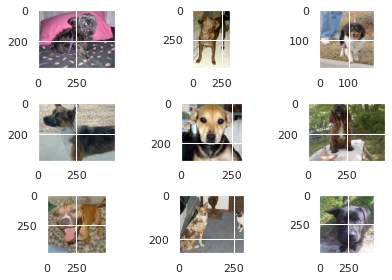

In [177]:
#Récuperer les datas (img chat/chien) sur kaggle et enregistrement dans la base de donnée django.
#On sépare les images de chien et les images de chat puis on cree des dossiers clean
folder = '../dogs_vs_cats/train_dog_cat/'

# All files and directories ending with .txt and that don't begin with a dot:
files = glob.glob(folder+"/*.jpg")
files
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



In [178]:

# empty list
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # make dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target

In [179]:
dataset.head(10)

,image_path,target
0,../dogs_vs_cats/train_dog_cat/dog.5878.jpg,dog
1,../dogs_vs_cats/train_dog_cat/cat.6562.jpg,cat
2,../dogs_vs_cats/train_dog_cat/cat.12376.jpg,cat
3,../dogs_vs_cats/train_dog_cat/cat.5486.jpg,cat
4,../dogs_vs_cats/train_dog_cat/cat.3740.jpg,cat
5,../dogs_vs_cats/train_dog_cat/cat.9864.jpg,cat
6,../dogs_vs_cats/train_dog_cat/cat.5723.jpg,cat
7,../dogs_vs_cats/train_dog_cat/dog.6691.jpg,dog
8,../dogs_vs_cats/train_dog_cat/dog.852.jpg,dog
9,../dogs_vs_cats/train_dog_cat/cat.4268.jpg,cat


In [180]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
dog    12500
cat    12500
Name: target, dtype: int64


## Data distribution

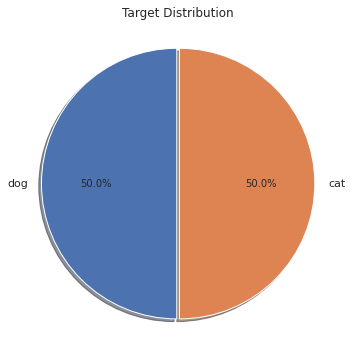

In [181]:
label_count=dataset['target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()


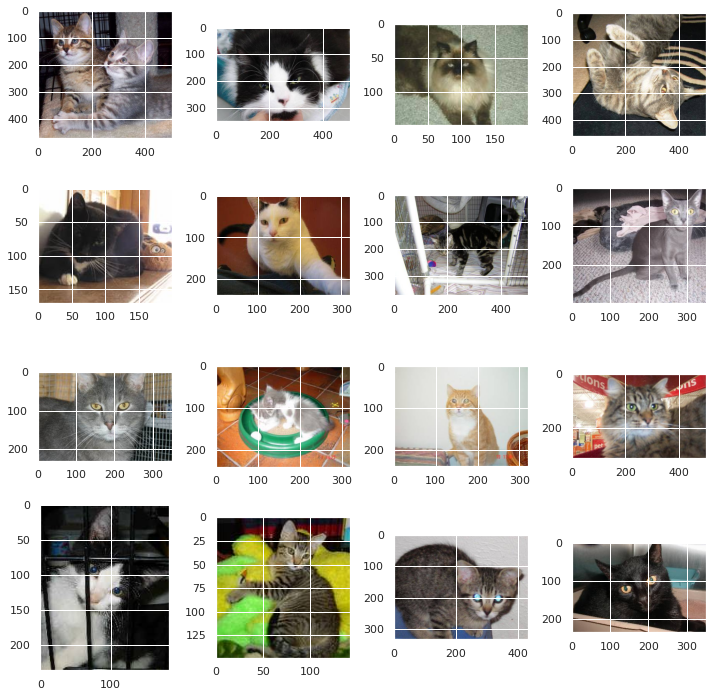

In [182]:
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0

for a in range(rows*cols):
    b = img.imread(train_cats_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

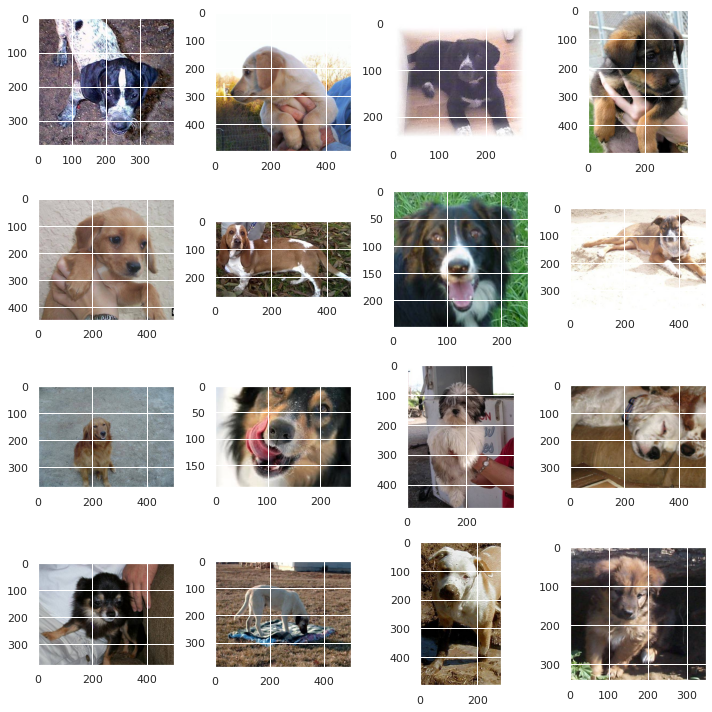

In [183]:
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0

for a in range(rows*cols):
    b = img.imread(train_dogs_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

## Splitting dataset

In [184]:
#Settings seed


'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [185]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=seed)

## 5.1 Image DataGenerator

When there is little data to train, we have to use ImageDataGenerator to increase the number of data. It is recommended to use only scaling for test data.

    rescale = 1./255 : change the value between 0 and 1

    rotation_range = 15 : Random rotation within 15 degrees

    shear_range = 0.1 : shear range 10%

    zoom_range = 0.2 : zoom range 20%

    horizontal_flip = True : Randomly flip horizontally.

    width_shift_range = 0.1 : Randomly move the original image horizontally within 10% of the width

    height_shift_range=0.1 : Randomly move the original image vertically within 10% of the width


In [186]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [187]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [188]:
## Making CNN Model


model = Sequential() # implement model layer 
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(WIDTH, HEIGHT, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [189]:
#from tensorflow.keras.utils import plot_model
#from IPython.display import Image
#plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
#Image(filename='convnet.png')


In [190]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [191]:
History=model.fit(train_datagenerator,
                     epochs=50,
                      validation_data=test_datagenerator,
                      validation_steps=dataset_test.shape[0]/150,
                      steps_per_epoch=dataset_train.shape[0]/150)

In [192]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.savefig('../dogs_vs_cats/fig/')

In [193]:
#model.save('../dogs_vs_cats/model_dog_cat')

In [194]:
model = keras.models.load_model('../dogs_vs_cats/model_dog_cat')

In [195]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 128)               43655296  
                                                      

In [196]:
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(150, 150))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 150, 150, 3)
    # center pixel data
    #img = img.astype('float32')
    #img = img - [123.68, 116.779, 103.939]
    return img

In [199]:
img = load_image("../dogs_vs_cats/babord-tribord-poupe.png")
result = model.predict(img)
result
#axios return result dog == 1 , chat == 0  


array([[0.]], dtype=float32)